# CS 301 Final Project – Wine Quality (Red) Classification

**Dataset**: Red Wine Quality (UCI version, local copy `winequality-red.csv`)  
**Goal**: Use physicochemical measurements of red wine to predict its quality score (multi-class classification).  
**Models**: Logistic Regression (multinomial) and Neural Network (MLP).  


In [24]:
# Task 0: Imports and basic config

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix
)

from sklearn.utils.class_weight import compute_sample_weight

sns.set(style="whitegrid", context="notebook")
plt.rcParams["figure.figsize"] = (8, 5)
RANDOM_STATE = 50


In [25]:
df = pd.read_csv("winequality-red.csv")

## Task 1: Exploratory Data Analysis (EDA)


In [26]:
# Shape and basic info
print("Shape:", df.shape)
print("\nInfo:")
print(df.info())

print("\nFirst 5 rows:")
display(df.head())


Shape: (1599, 12)

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB
None

First 5 rows:


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [27]:
# Summary statistics
display(df.describe().T)

# Check for missing values
print("\nMissing values per column:")
print(df.isna().sum())


,count,mean,std,min,25%,50%,75%,max
fixed acidity,1599.0,8.319637,1.741096,4.60000,7.1000,7.90000,9.200000,15.90000
volatile acidity,1599.0,0.527821,0.179060,0.12000,0.3900,0.52000,0.640000,1.58000
citric acid,1599.0,0.270976,0.194801,0.00000,0.0900,0.26000,0.420000,1.00000
residual sugar,1599.0,2.538806,1.409928,0.90000,1.9000,2.20000,2.600000,15.50000
chlorides,1599.0,0.087467,0.047065,0.01200,0.0700,0.07900,0.090000,0.61100
free sulfur dioxide,1599.0,15.874922,10.460157,1.00000,7.0000,14.00000,21.000000,72.00000
total sulfur dioxide,1599.0,46.467792,32.895324,6.00000,22.0000,38.00000,62.000000,289.00000
density,1599.0,0.996747,0.001887,0.99007,0.9956,0.99675,0.997835,1.00369
pH,1599.0,3.311113,0.154386,2.74000,3.2100,3.31000,3.400000,4.01000
sulphates,1599.0,0.658149,0.169507,0.33000,0.5500,0.62000,0.730000,2.00000



Missing values per column:
fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64


Counts per quality score:
 quality
3     10
4     53
5    681
6    638
7    199
8     18
Name: count, dtype: int64

Proportion per quality score:
 quality
3    0.006254
4    0.033146
5    0.425891
6    0.398999
7    0.124453
8    0.011257
Name: proportion, dtype: float64


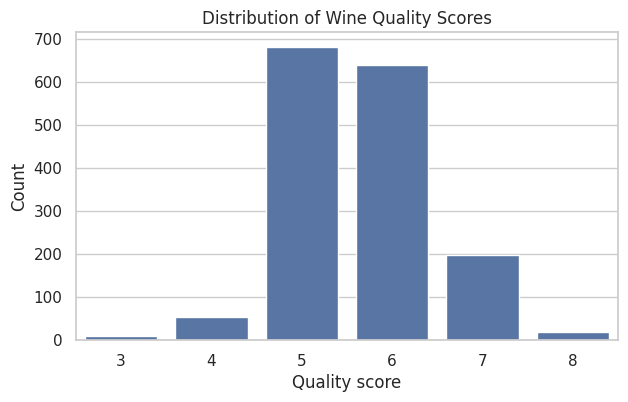

In [28]:
# Quality distribution
quality_counts = df["quality"].value_counts().sort_index()
quality_probs = df["quality"].value_counts(normalize=True).sort_index()

print("Counts per quality score:\n", quality_counts)
print("\nProportion per quality score:\n", quality_probs)

plt.figure(figsize=(7, 4))
sns.barplot(x=quality_counts.index, y=quality_counts.values)
plt.xlabel("Quality score")
plt.ylabel("Count")
plt.title("Distribution of Wine Quality Scores")
plt.show()


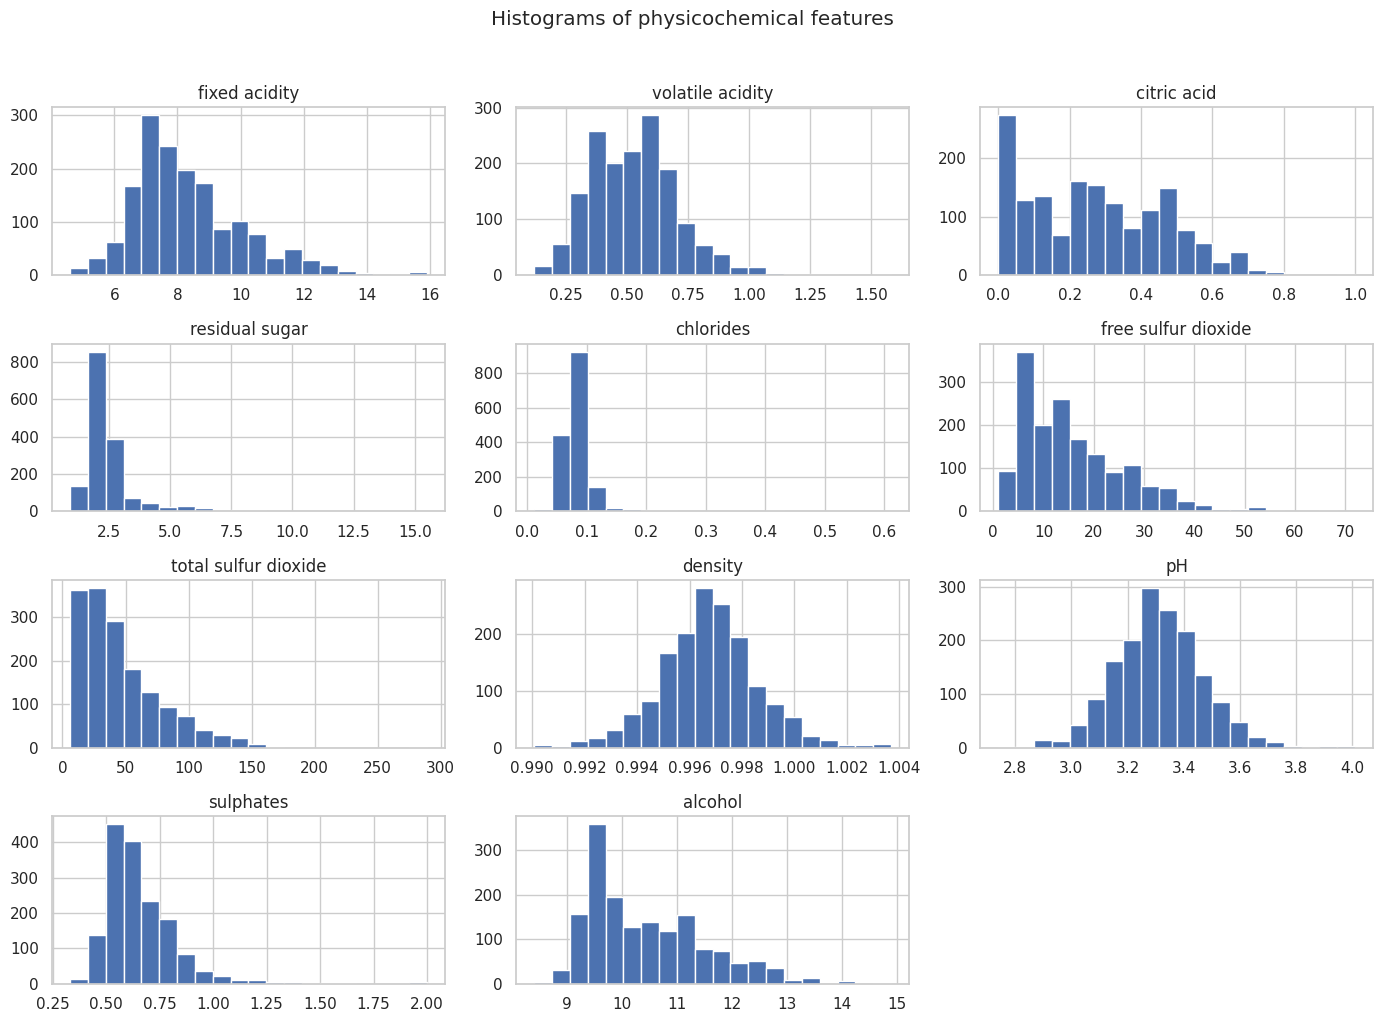

In [29]:
feature_cols = [c for c in df.columns if c != "quality"]

df[feature_cols].hist(bins=20, figsize=(14, 10))
plt.suptitle("Histograms of physicochemical features", y=1.02)
plt.tight_layout()
plt.show()


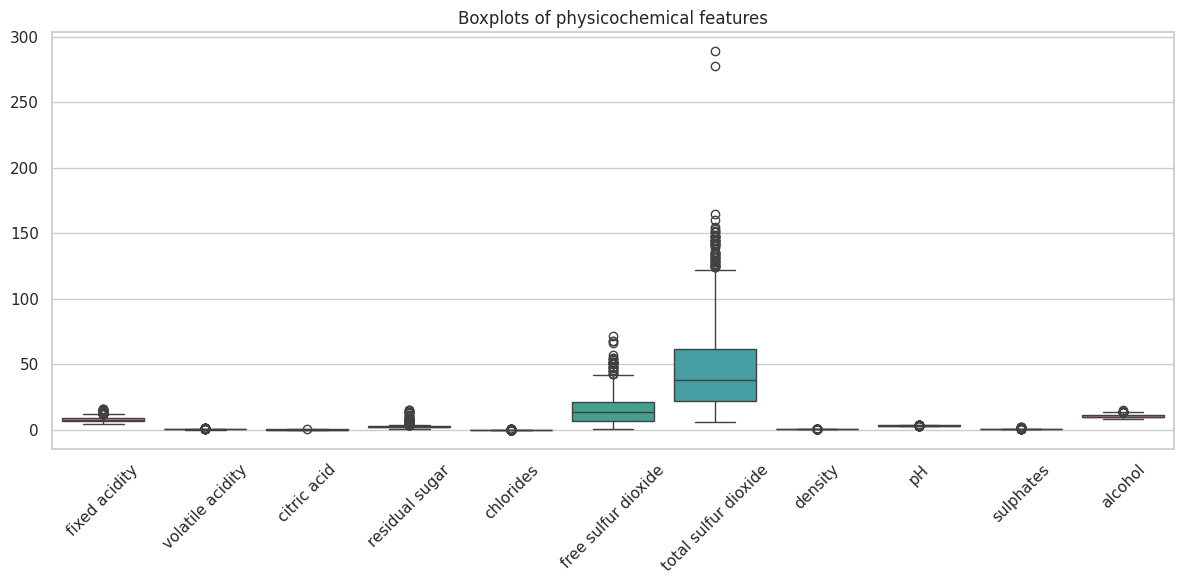

In [30]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df[feature_cols])
plt.xticks(rotation=45)
plt.title("Boxplots of physicochemical features")
plt.tight_layout()
plt.show()


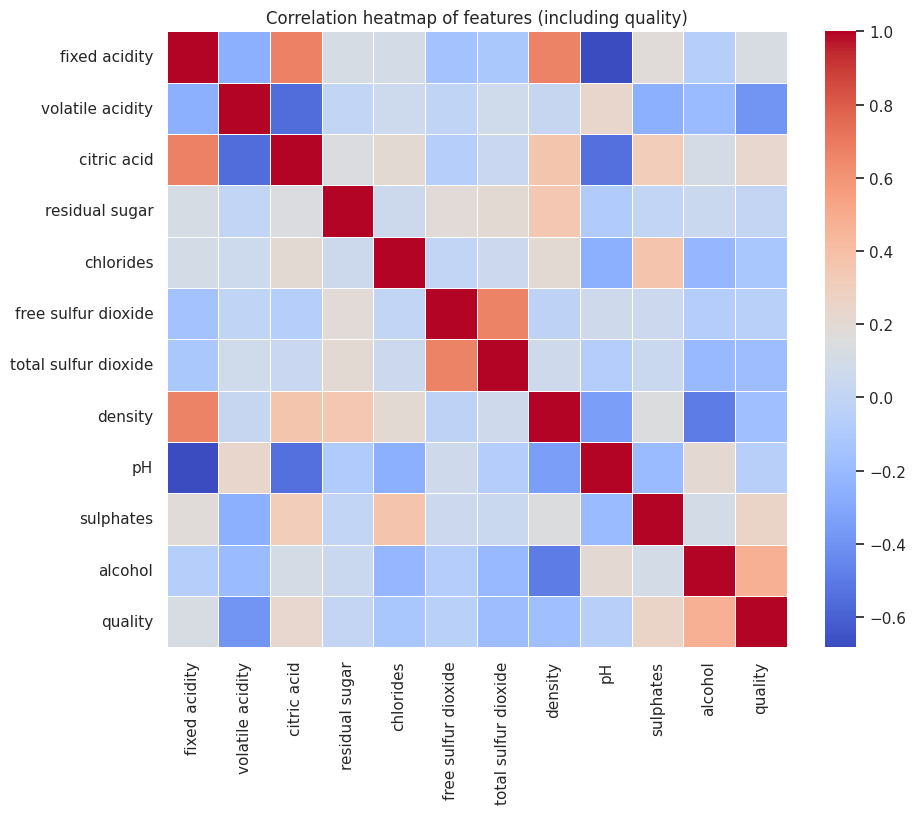

In [31]:
plt.figure(figsize=(10, 8))
corr = df.corr(numeric_only=True)
sns.heatmap(corr, annot=False, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation heatmap of features (including quality)")
plt.show()


### EDA Summary



- **Background**: The red wine quality dataset contains 1599 samples of Portuguese red wine.
  Each row is a wine sample, and columns include 11 physicochemical measurements
  (such as fixed acidity, residual sugar, chlorides, alcohol) plus a quality score from 3 to 8.
  
- **Goal**: Predict the quality score (multi-class classification) using the measurements.

- **Key observations from summary statistics**:

  - Residual sugar is extremely right skewed and contains extreme outliers
  - Chlorides are right skewed with a mean of 0.087, suggesting mostly low-salt wines in this dataset with some outliers
  - Both Sulfur dioxide graphs have right skews with long tails
  - Citric Acid is both right skewed and slight bimodal which might hint at two underlying groups (production method, style, etc.)
  - Alcohol and Sulphates are mildly right skewed.
  - Density and pH have the smallest ranges while total sulfur dioxide has the

  - Fixed Acidity has strong positive correlations with Citric acid and Density
  - Free SO and Total SO are also positive correlations which is expected since they are related

  - Fixed acidity and pH have a strong negative correlation which is expected since higher acid = lower pH
  - Alcohol and Density are negatively correlated because alcohol is less dense than water
  - Citric acid and volatile acidity are negatively correlated
  
  - Alcohol has a positive correlation with quality - higher alcohol wines rate better
  - Volatile acidity has a negative correlation with quality - higher volatile acidity is undesirable
  - All other variables have weak correlations with quality meaning classifying wine quality is complex, and not easily predicted with single variables.

- **Implications**:
    - Log transformation of skewed features
    - Standardization of all features to ensure fair comparisons between features of different ranges and reduce impact of outliers

- **Missing values**:
  - `df.isna().sum()` shows 0 missing values for all columns, an imputer is not needed for this dataset.

- **Class balance**:
  - Quality scores 5 and 6 dominate the dataset (together ~80% of samples),
    while very high (8) and very low (3) quality wines are rare.
  - This means the dataset is **imbalanced** toward medium-quality wines.

- **Implications**:
  - Implement class weights to help with imbalance
  - Simplify quality classes (6 classes to 3 classes) to help with imbalance




## Task 2: Data Pre-processing


In [32]:
# Features (X) and target (y)
X = df.drop(columns=["quality"])
y = df["quality"]

# Train / temp (val+test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X,
    y,
    test_size=0.4,
    random_state=RANDOM_STATE,
    stratify=y
)

# Split temp into validation and test sets (each 20% of original data)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp,
    y_temp,
    test_size=0.5,
    random_state=RANDOM_STATE,
    stratify=y_temp
)



print("Train shape:", X_train.shape)
print("Validation shape:", X_val.shape)
print("Test shape:", X_test.shape)


Train shape: (959, 11)
Validation shape: (320, 11)
Test shape: (320, 11)


In [33]:
X_train_eng = X_train.copy()
X_val_eng = X_val.copy()
X_test_eng = X_test.copy()

skewed_features = ['residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'sulphates']

for feature in skewed_features:
    X_train_eng[feature] = np.log1p(X_train_eng[feature])
    X_val_eng[feature] = np.log1p(X_val_eng[feature])
    X_test_eng[feature] = np.log1p(X_test_eng[feature])

#convert the 6 classes into three classes for balance
def simplify_quality(y):
    return np.where(y <= 4, 0, np.where(y <= 6, 1, 2))

y_train_simple = simplify_quality(y_train)
y_val_simple = simplify_quality(y_val)
y_test_simple = simplify_quality(y_test)



In [34]:
#standardizing features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_eng)
X_val_scaled = scaler.fit_transform(X_val_eng)
X_test_scaled = scaler.fit_transform(X_test_eng)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train_eng.columns)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=X_val_eng.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test_eng.columns)


In [35]:
#Handle Class Imbalance with weights

X_train_balanced = X_train_scaled
y_train_balanced = y_train_simple

## Task 3: Build Your Models

We treat this as a **multi-class classification** problem:
- Target: `quality` (values 3, 4, 5, 6, 7, 8).
- Input features: 11 physicochemical measurements.


In [36]:
models = {}
results = []

log_reg_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(
        max_iter=1000,
        class_weight='balanced',
        solver="lbfgs",
        random_state=RANDOM_STATE
    ))
])

# Train on training set
log_reg_clf.fit(X_train_balanced, y_train_balanced)
models['Logistic Regression'] = log_reg_clf


In [37]:
mlp_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", MLPClassifier(
        hidden_layer_sizes=(128, 64, 32),  # two hidden layers
        activation="relu",
        solver="adam",
        learning_rate_init=0.001,
        max_iter=1000,
        random_state=RANDOM_STATE
    ))
])

mlp_clf.fit(X_train_balanced, y_train_balanced)
models['Neural Network'] = mlp_clf


### Model Design Choices

**Problem type**

- This is a **multi-class classification** problem. Each wine sample is assigned
  a discrete quality label (Low (3-4) - Medium (5-6) - High (7-8)), so classification methods are appropriate.

**Model 1 – Multinomial Logistic Regression**
- **Hypothesis class**: Linear model. It learns a set of linear decision boundaries
  in the feature space and uses the softmax function to output class probabilities.
- **Loss function**: Multi-class cross-entropy (negative log-likelihood).
  This is appropriate because it directly measures how well predicted probabilities
  match the true class labels.
- **Optimization algorithm**: We use the `lbfgs` quasi-Newton method implemented in
  `sklearn.linear_model.LogisticRegression`. It is efficient and stable for
  medium-sized datasets and convex objectives like logistic regression.

**Model 2 – Neural Network (MLPClassifier)**
- **Hypothesis class**: Feed-forward neural network with three hidden layers of sizes 128, 64 and 32,
  and ReLU activation. This is a more flexible, non-linear function class that can capture
  complex relationships between features and wine quality.
- **Loss function**: Multi-class cross-entropy (implemented internally as
  the log-loss for classification). This is standard for training neural networks
  on classification tasks.
- **Optimization algorithm**: Adam (Adaptive Moment Estimation), a variant of stochastic
  gradient descent that adapts learning rates per parameter. Adam typically converges
  faster and requires less manual tuning than basic SGD, which is useful for this project.


## Task 4: Test and Evaluate the Models


In [38]:
label_names = ['Low (3-4)', 'Medium (5-6)', 'High (7-8)']

for model_name, model in models.items():
    print(f"{model_name}")

    y_test_pred = model.predict(X_test_scaled)
    y_val_pred = model.predict(X_val_scaled)

    acc = accuracy_score(y_test_simple, y_test_pred)
    f1_macro = f1_score(y_test_simple, y_test_pred, average='macro')

    val_acc = accuracy_score(y_val_simple, y_val_pred)
    val_f1_macro = f1_score(y_val_simple, y_val_pred, average='macro')

    results.append({
        'Model': model_name,
        'Test Accuracy': acc,
        'Test Macro F1': f1_macro,
        'Val Accuracy': val_acc,
        'Val Macro F1': val_f1_macro,
        'Generalization Gap': abs(acc - val_acc)})

    print(f"\n TEST SET PERFORMANCE:\n")
    print(f"   Accuracy:          {acc:.4f}")
    print(f"   Balanced Accuracy: {val_acc:.4f}")
    print(f"   Macro F1:          {f1_macro:.4f}")

    print(f"\n VALIDATION SET PERFORMANCE:\n")
    print(f"   Accuracy:          {val_acc:.4f}")
    print(f"   Macro F1:          {val_f1_macro:.4f}")

    print(f"\nGeneralization Gap: {abs(acc - val_acc):.4f}")

    print("\nClassification report (TEST):\n", classification_report(y_test_simple, y_test_pred))

    print("\nClassification report (VAL):\n", classification_report(y_val_simple, y_val_pred))

Logistic Regression

 TEST SET PERFORMANCE:

   Accuracy:          0.6219
   Balanced Accuracy: 0.5969
   Macro F1:          0.4834

 VALIDATION SET PERFORMANCE:

   Accuracy:          0.5969
   Macro F1:          0.4608

Generalization Gap: 0.0250

Classification report (TEST):
               precision    recall  f1-score   support

           0       0.10      0.46      0.16        13
           1       0.94      0.58      0.72       263
           2       0.41      0.91      0.57        44

    accuracy                           0.62       320
   macro avg       0.48      0.65      0.48       320
weighted avg       0.83      0.62      0.68       320


Classification report (VAL):
               precision    recall  f1-score   support

           0       0.11      0.58      0.18        12
           1       0.93      0.57      0.70       265
           2       0.36      0.79      0.50        43

    accuracy                           0.60       320
   macro avg       0.47      0.65  

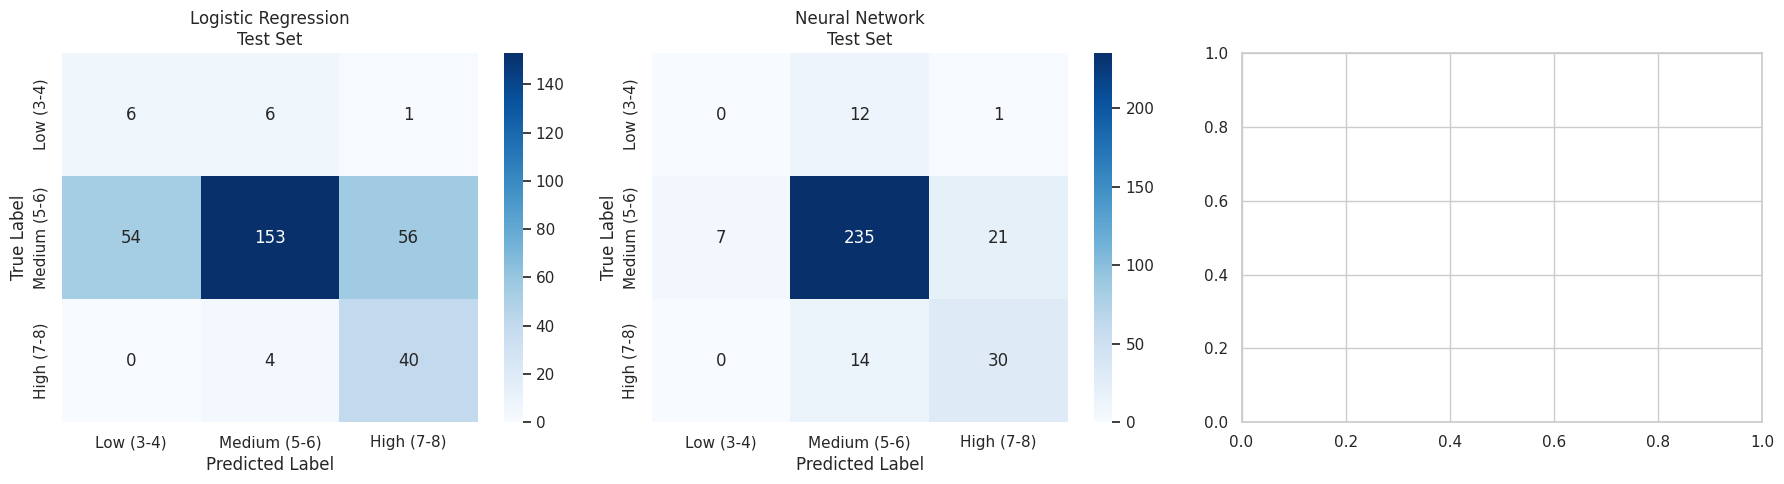

In [39]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (model_name, model) in enumerate(models.items()):
    y_test_pred = model.predict(X_test_scaled)
    cm = confusion_matrix(y_test_simple, y_test_pred)

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_names,
                yticklabels=label_names,
                ax=axes[idx])
    axes[idx].set_xlabel('Predicted Label')
    axes[idx].set_ylabel('True Label')
    axes[idx].set_title(f'{model_name}\nTest Set')

plt.tight_layout()
plt.show()


## Task 5: Comparison and Discussion

- **Overall performance**:
  - Both models adequately were able to predict wine quality into 3 categories. However, the Neural Network significantly outperformed the Logistic Regression model across all metrics.
  - The NN acheived 82.8% test accuracy with a macro F1-score of 0.507
  - Logisitc Regression acheieved 62.2% test accuracy with 0.483 macro F1-score.
  - Both models had good generalization with the test and validation accuracies being withing 3% of eachother demonstrating minimal overfitting

- **Strengths of Logistic Regression**:
  - Simple and interpretable linear model. You can inspect the learned coefficients to
    see how each feature influences the log-odds of each quality class.
  - Trains very quickly and is less sensitive to hyperparameter choices.
  - This model performed well on high quality wines with 91% recall, and had good generalizatoin with a 3.1% gap.

- **Weaknesses of Logistic Regression**:
  - This model failed to predict low quality wines with a 0% recall on the test set.
  - Overall accuracy was 62.2% which is significatnyl lower than the NN
  - Confusion matrix shows significant misclassification between categories, with 54 medium wines incorrectly classified as Low, and 56 as High.
  - Since Linear Regression assumes linear relationships, it ability to predict complex relationships such as this one likely was the main factor limiting its performance

- **Strengths of the Neural Network (MLP)**:
  - Can model non-linear relationships due to multiple hidden layers and ReLU activation.
  - With good hyperparameters and enough training, it may achieve higher performance
    than logistic regression on more complex datasets such as this one.
  - This was the case as the test accuracy was 82.8% and generalization was very good with only a 2.2% gap between accuracies.
  - It preformed very well on medium wines with 90% preicson and 89% recall.

- **Weaknesses of the Neural Network**:
  - Less interpretable; hard to explain exactly why a particular prediction was made.
  - More sensitive to hyperparameters and random initialization.
  - Training takes longer and can be affected by local minima or convergence issues.
  - This model also failed to predict low quality wines.

- **Data imbalance considerations**:
  - A major challenge affecting both models was severe data imbalance. There were very few wines (4%) labeled low quailty and many wines labeled 5 or 6 (82%). This can hurt macro-averaged F1 since rare classes are harder to predict correctly.
  - This imbalance was the reason both models had a 0% recall on low quality wines as there simply wasn't enough data to teach the models how to predict them.
  - Ultimately this is a data problem rather than a modeling failure as even much better models would have a hard time with this little data.

- **Conclusion of comparison**:
  - Without a doubt the Neural Network is the superior model for this wine quality classifcation with 82.8% accuracy comapred the logistic regressions 62.2%.
  - This was likely due to the NN ability to model complex non-linear relationship such as this one where most of the data features as had weak correlations with the target features.
  - However, while both models demonstrated good generalization and minimal overfitting, a major flaw was both models inability to predict low quality wines.
  - This was ultimatley a data problem rather than a modeling problem as the other categories acheived acceptable and in some cases excellent performance, but the limited amount of low quality wine data is an issue even more sophisticated models would struggle with.
